<a href="https://colab.research.google.com/github/nithyasreesanaka/Projects-Eng-/blob/main/cervical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/Datacancer.zip

Archive:  /content/drive/MyDrive/Datacancer.zip
   creating: Datacancer/test/
   creating: Datacancer/test/Dys-30/
  inflating: Datacancer/test/Dys-30/071.bmp  
  inflating: Datacancer/test/Dys-30/072.bmp  
  inflating: Datacancer/test/Dys-30/073.bmp  
  inflating: Datacancer/test/Dys-30/074.bmp  
  inflating: Datacancer/test/Dys-30/075.bmp  
  inflating: Datacancer/test/Dys-30/076.bmp  
  inflating: Datacancer/test/Dys-30/077.bmp  
  inflating: Datacancer/test/Dys-30/078.bmp  
  inflating: Datacancer/test/Dys-30/079.bmp  
  inflating: Datacancer/test/Dys-30/080.bmp  
  inflating: Datacancer/test/Dys-30/081.bmp  
  inflating: Datacancer/test/Dys-30/082.bmp  
  inflating: Datacancer/test/Dys-30/083.bmp  
  inflating: Datacancer/test/Dys-30/084.bmp  
  inflating: Datacancer/test/Dys-30/085.bmp  
  inflating: Datacancer/test/Dys-30/086.bmp  
  inflating: Datacancer/test/Dys-30/087.bmp  
  inflating: Datacancer/test/Dys-30/088.bmp  
  inflating: Datacancer/test/Dys-30/089.bmp  
  inflating

In [ ]:
import os
import numpy as np
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization
# from keras.layers.normalization import BatchNormalization
from keras.layers import *
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
from keras.callbacks import History
history = History()

from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.layers import Conv2D,MaxPool2D,GlobalAveragePooling2D,AveragePooling2D
from keras.layers import Activation, Dense, Dropout
from keras.models import Model

In [ ]:
train_path = "/content/Datacancer/train"
test_path = "/content/Datacancer/test_copy"
#valid_path = "/content/DataPro/validate"

In [ ]:
train_batches = ImageDataGenerator(rotation_range=10, width_shift_range=0.1,
       height_shift_range=0.1, shear_range=0.15, zoom_range=0.1,
       channel_shift_range=10., horizontal_flip=True).flow_from_directory(train_path, target_size=(224,224), classes =['Dys-70','Koi-70','Met-70','Par-70','Sup-70'], batch_size=32)
test_batches = ImageDataGenerator(rotation_range=10, width_shift_range=0.1,
       height_shift_range=0.1, shear_range=0.15, zoom_range=0.1,
       channel_shift_range=10., horizontal_flip=True).flow_from_directory(test_path, target_size=(224,224), classes =['Dys-30','Koi-30','Met-30','Par-30','Sup-30'], batch_size=32)

Found 350 images belonging to 5 classes.
Found 150 images belonging to 5 classes.


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                         title = 'Confusion Matrix',
                         cmap=plt.cm.Blues):

  plt.imshow(cm, interpolation = 'nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation = 45)
  plt.yticks(tick_marks, classes)

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1) [:, np.newaxis]
    print("Normalized Confusion Matrix")
  else:
    print("Confusion Matrix without normalization")

  print(cm)

  thresh = cm.max() / 2.

  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j,i, cm[i,j],
            horizontalalignment ="center",
            color = "white" if cm[i,j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
try: # detect TPUs
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
  strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs
  strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
  #strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines

print("Number of accelerators: ", strategy.num_replicas_in_sync)

Number of accelerators:  1


In [ ]:

IMAGE_SIZE = [224, 224]

In [ ]:

with strategy.scope():  # Ensure all operations are within this scope
    bnmomemtum = 0.9

    def attention_module(x):
        """Apply channel-wise attention using fully connected layers."""
        channel = x.shape[-1]  # Number of channels in the input
        gap = tf.keras.layers.GlobalAveragePooling2D()(x)  # Global Average Pooling
        dense1 = tf.keras.layers.Dense(units=channel // 4, activation='relu')(gap)  # Bottleneck FC Layer
        dense2 = tf.keras.layers.Dense(units=channel, activation='sigmoid')(dense1)  # Attention Weights
        attention_weights = tf.keras.layers.Reshape((1, 1, channel))(dense2)  # Reshape for broadcasting
        return tf.keras.layers.Multiply()([x, attention_weights])  # Apply attention

    def fire(x, squeeze, expand):
        y = tf.keras.layers.Conv2D(filters=squeeze, kernel_size=1, activation='relu', padding='same')(x)
        y = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y)
        y1 = tf.keras.layers.Conv2D(filters=expand // 2, kernel_size=1, activation='relu', padding='same')(y)
        y1 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y1)
        y3 = tf.keras.layers.Conv2D(filters=expand // 2, kernel_size=3, activation='relu', padding='same')(y)
        y3 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y3)
        fire_output = tf.keras.layers.concatenate([y1, y3])
        return attention_module(fire_output)  # Apply attention after the Fire module output

    def fire_module(squeeze, expand):
        return lambda x: fire(x, squeeze, expand)

    x = tf.keras.layers.Input(shape=[*IMAGE_SIZE, 3])  # Input is 192x192 pixels RGB 24,32,68

    y = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', use_bias=True, activation='relu')(x)
    y = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y)
    y = fire_module(24, 48)(y)
    y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
    y = fire_module(48, 96)(y)
    y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
    y = fire_module(64, 128)(y)
    y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
    y = fire_module(48, 96)(y)
    y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
    y = fire_module(24, 48)(y)
    y = tf.keras.layers.GlobalAveragePooling2D()(y)
    y = tf.keras.layers.Dense(5, activation='softmax')(y)

    model = tf.keras.Model(x, y)
    adam = tf.keras.optimizers.Adam(learning_rate=0.0001)

    model.compile(
        optimizer=adam,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    model.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 224, 224, 32)   │            896 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_16    │ (None, 224, 224, 32)   │            128 │ conv2d_16[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_17 (Conv2D)        │ (None, 224, 224, 24)   │            792 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_17    │ (None, 224, 224, 24)   │             96 │ conv2d_17[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_18 (Conv2D)        │ (None, 224, 224, 24)   │            600 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 224, 224, 24)   │          5,208 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_18    │ (None, 224, 224, 24)   │             96 │ conv2d_18[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_19    │ (None, 224, 224, 24)   │             96 │ conv2d_19[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_5             │ (None, 224, 224, 48)   │              0 │ batch_normalization_1… │
│ (Concatenate)             │                        │                │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 48)             │              0 │ concatenate_5[0][0]    │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 12)             │            588 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 48)             │            624 │ dense_11[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_5 (Reshape)       │ (None, 1, 1, 48)       │              0 │ dense_12[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_5 (Multiply)     │ (None, 224, 224, 48)   │              0 │ concatenate_5[0][0],   │
│                           │                        │                │ reshape_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4      

 Total params: 140,845 (550.18 KB)

 Trainable params: 139,533 (545.05 KB)

 Non-trainable params: 1,312 (5.12 KB)

In [ ]:
# Train the Model
history = model.fit(train_batches,
                    epochs=30,
                    validation_data=test_batches,
                    callbacks=[
                        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=30),
                        tf.keras.callbacks.ModelCheckpoint('models/model_{val_accuracy:.3f}.keras',
                                                           save_best_only=True,
                                                           save_weights_only=False,
                                                           monitor='val_accuracy')
                    ])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.2829 - loss: 1.5773 - val_accuracy: 0.2267 - val_loss: 1.6111
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.7593 - loss: 1.2606 - val_accuracy: 0.2667 - val_loss: 1.5791
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 894ms/step - accuracy: 0.8186 - loss: 1.0767 - val_accuracy: 0.7667 - val_loss: 1.1899
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.8463 - loss: 0.9477 - val_accuracy: 0.7800 - val_loss: 0.9131
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8205 - loss: 0.8451 - val_accuracy: 0.8133 - val_loss: 0.7423
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8554 - loss: 0.7792 - val_accuracy: 0.8067 - val_loss: 0.6760
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8818 - loss: 0.6512 - val_accuracy: 0.8400 - val_loss: 0.6462
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 988ms/step - accuracy: 0.8783 - loss: 0.6371 - val_accuracy: 0.8067 - val

In [ ]:
def plots(ims, figsize=(12,6), rows=2, interp=False, titles=None):
  if type(ims[0]) is np.ndarray:
    ims = np.array(ims).astype(np.uint8)
    if(ims.shape[-1] != 3):
      ims = ims.transpose ((0,2,3,1))
  f = plt.figure(figsize = figsize)
  cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows +1
  for i in range(len(ims)):
    sp = f.add_subplot (rows, cols, i+1)
    sp.axis('Off')
    if titles is not None:
      # Convert one-hot encoded label to class index and then to string
      title = str(np.argmax(titles[i]))
      sp.set_title(title, fontsize =10)
    plt.imshow(ims[i], interpolation=None if interp else 'none')

In [ ]:
test_batches_fine = ImageDataGenerator(rotation_range=10, width_shift_range=0.1,
       height_shift_range=0.1, shear_range=0.15, zoom_range=0.1,
       channel_shift_range=10., horizontal_flip=True).flow_from_directory(test_path, target_size=(224,224), classes =['Dys-30','Koi-30','Met-30','Par-30','Sup-30'], batch_size=50)

Found 150 images belonging to 5 classes.


In [ ]:
test_imgs, test_labels = next(test_batches_fine)

[1 0 3 3 4 1 4 0 2 2 1 1 3 4 3 2 3 0 3 4 4 1 0 4 0 3 4 3 2 3 2 1 0 2 1 4 1
 2 2 4 2 0 4 2 0 2 1 4 0 3]


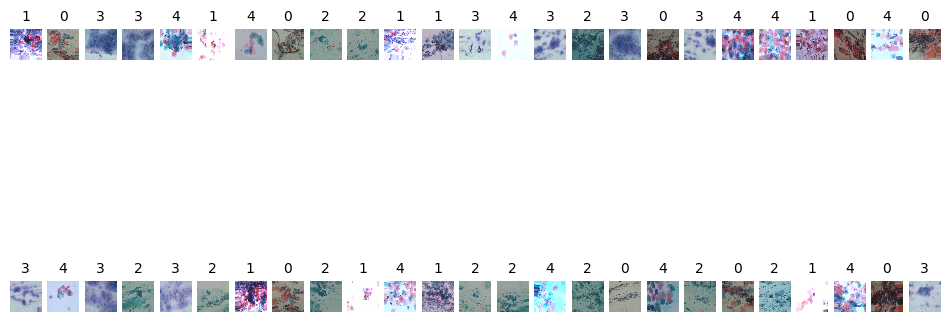

In [ ]:
x_labels = test_labels.argmax(axis=1)
print(x_labels)
plots(test_imgs, titles=test_labels)

In [ ]:
# predictions = model.predict(test_batches_fine, steps=1, verbose=0)

# loading the best perfoming model
loaded_model = tf.keras.models.load_model('/content/models/model_0.993.keras')

print('Caling test batches:', test_batches_fine)

predictions = loaded_model.predict(test_batches_fine, steps=1, verbose=0)
print(predictions)

# Getting test accuracy and loss
test_loss, test_acc = loaded_model.evaluate(test_batches_fine)
print('Test loss: {} Test Acc: {}'.format(test_loss, test_acc))

Caling test batches: <keras.src.legacy.preprocessing.image.DirectoryIterator object at 0x7c129d153f90>
[[0.01845195 0.8417143  0.03221845 0.01515563 0.09245966]
 [0.90235823 0.02278943 0.03682473 0.0250324  0.01299525]
 [0.02569976 0.01138231 0.01705604 0.92767584 0.01818602]
 [0.02137342 0.01240972 0.01594358 0.935899   0.01437421]
 [0.01639389 0.02419573 0.01401739 0.00829116 0.9371019 ]
 [0.0189705  0.89821637 0.03075642 0.02221343 0.02984329]
 [0.05595247 0.09718411 0.10119764 0.46604607 0.27961966]
 [0.75756186 0.03349829 0.15363477 0.03140271 0.02390242]
 [0.00587873 0.00565396 0.9784978  0.00520512 0.00476446]
 [0.00439819 0.00498184 0.9822729  0.00407245 0.00427461]
 [0.0175078  0.88017875 0.03147807 0.01436697 0.05646848]
 [0.01939472 0.8463754  0.02417457 0.0585563  0.05149907]
 [0.04987573 0.17961444 0.14755893 0.5905258  0.03242508]
 [0.0139131  0.02222243 0.01061782 0.00472589 0.9485208 ]
 [0.01049891 0.00450101 0.00760567 0.9732529  0.00414155]
 [0.02005732 0.01522645 0.9

In [ ]:
y_labels = predictions.argmax(axis=1)
y_labels

array([1, 0, 3, 3, 4, 1, 3, 0, 2, 2, 1, 1, 3, 4, 3, 2, 3, 0, 3, 4, 4, 1,
       0, 4, 0, 3, 4, 3, 2, 3, 2, 1, 0, 2, 1, 4, 1, 2, 2, 4, 2, 0, 4, 2,
       0, 2, 1, 4, 0, 3])

In [ ]:
from sklearn.metrics import classification_report
cm = confusion_matrix(x_labels, y_labels)
tp, fn, fp, tn = confusion_matrix(x_labels,y_labels,labels=[1,0]).reshape(-1)
print('Outcome values :tp, fn, fp, tn: \n', tp, fn, fp, tn)
# classification report for precision, recall f1-score and accuracy
matrix = classification_report(x_labels,y_labels,labels=[1,0])
print('Classification report : \n',matrix)

Outcome values :tp, fn, fp, tn: 
 9 0 0 9
Classification report : 
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         9
           0       1.00      1.00      1.00         9

   micro avg       1.00      1.00      1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18



In [ ]:
cm_plot_labels = ['Dys-30','Koi-30','Met-30','Par-30','Sup-30']

Confusion Matrix without normalization
[[ 9  0  0  0  0]
 [ 0  9  0  0  0]
 [ 0  0 11  0  0]
 [ 0  0  0 10  0]
 [ 0  0  0  1 10]]


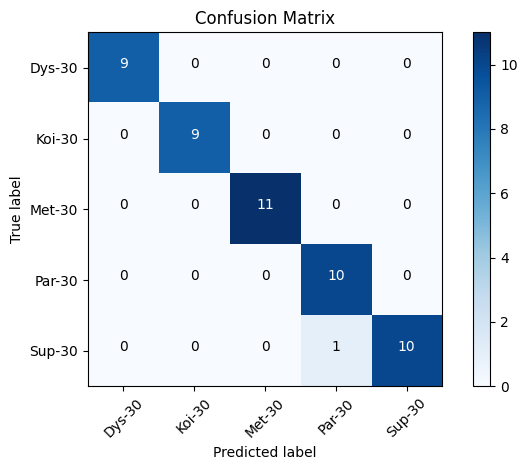

In [ ]:
plot_confusion_matrix(cm, cm_plot_labels, title ='Confusion Matrix')

In [ ]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


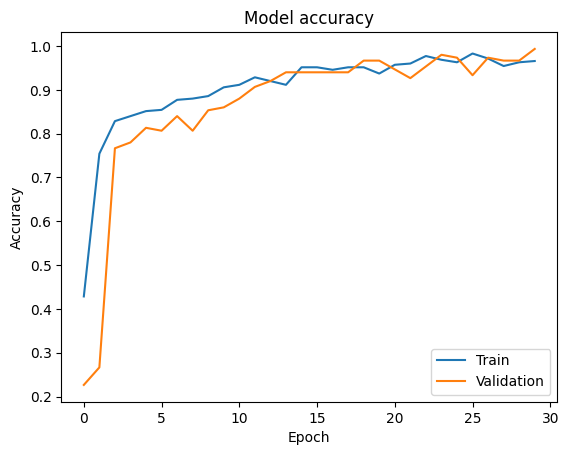

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()


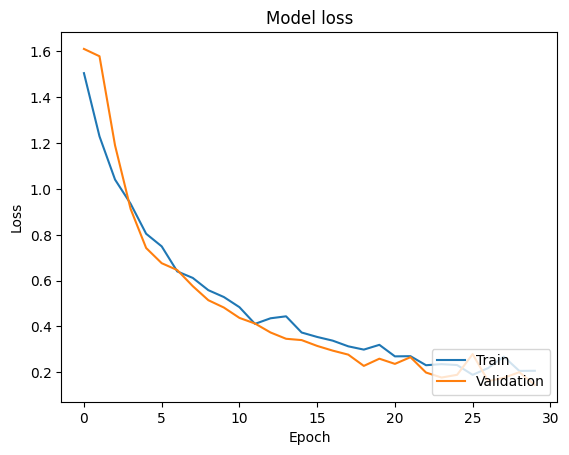

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [ ]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load your trained model
model = tf.keras.models.load_model("/content/models/model_0.993.keras")  # Replace with the actual model path

# Define the last convolutional layer from your architecture
last_conv_layer_name = "conv2d_4"  # Replace with your last Conv2D layer's name (verify with `model.summary()`)

# Submodel to get the outputs of the last convolutional layer
last_conv_layer_model = Model(inputs=model.input,
                              outputs=model.get_layer(last_conv_layer_name).output)

# Load and preprocess the input image
img_path = "/content/Datacancer/train/Koi-70/047.bmp"  # Replace with your image path
img = load_img(img_path, target_size=(224, 224))  # Resize to your model's input size
img_array = img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Get feature maps from the last convolutional layer
conv_output = last_conv_layer_model(img_array)

# Get the weights of the dense (output) layer
dense_layer_weights = model.layers[-1].get_weights()[0]  # Weights of the Dense layer
target_class = 0  # Replace with your desired class index
class_weights_for_target = dense_layer_weights[:, target_class]

# Compute the weighted sum of the feature maps
conv_output = conv_output[0]  # Remove batch dimension
heatmap = np.dot(conv_output, class_weights_for_target)

# Apply ReLU and normalize the heatmap
heatmap = np.maximum(heatmap, 0)  # Apply ReLU
heatmap /= np.max(heatmap)  # Normalize to [0, 1]

# Resize heatmap to match the original image size
heatmap = tf.image.resize(heatmap[..., np.newaxis], (img.size[1], img.size[0])).numpy().squeeze()

heatmap = np.uint8(255 * heatmap)  # Scale to [0, 255]
heatmap_colored = plt.cm.jet(heatmap)[:, :, :3]  # Apply 'jet' colormap and remove alpha channel
heatmap_colored = (heatmap_colored * 255).astype(np.uint8)  # Convert to uint8

# Blend the heatmap with the original image
original_img = img_to_array(load_img(img_path))  # Load original image
original_img = original_img.astype(np.uint8)
original_img = cv2.resize(original_img, (heatmap_colored.shape[1], heatmap_colored.shape[0]))
overlay = cv2.addWeighted(original_img, 0.6, heatmap_colored, 0.4, 0)  # Blend with alpha blending

# Display the resulting heatmap overlay
plt.imshow(overlay)
plt.axis('off')
plt.show()


ValueError: No such layer: conv2d_4. Existing layers are: ['input_layer_1', 'conv2d_16', 'batch_normalization_16', 'conv2d_17', 'batch_normalization_17', 'conv2d_18', 'conv2d_19', 'batch_normalization_18', 'batch_normalization_19', 'concatenate_5', 'global_average_pooling2d_6', 'dense_11', 'dense_12', 'reshape_5', 'multiply_5', 'max_pooling2d_4', 'conv2d_20', 'batch_normalization_20', 'conv2d_21', 'conv2d_22', 'batch_normalization_21', 'batch_normalization_22', 'concatenate_6', 'global_average_pooling2d_7', 'dense_13', 'dense_14', 'reshape_6', 'multiply_6', 'max_pooling2d_5', 'conv2d_23', 'batch_normalization_23', 'conv2d_24', 'conv2d_25', 'batch_normalization_24', 'batch_normalization_25', 'concatenate_7', 'global_average_pooling2d_8', 'dense_15', 'dense_16', 'reshape_7', 'multiply_7', 'max_pooling2d_6', 'conv2d_26', 'batch_normalization_26', 'conv2d_27', 'conv2d_28', 'batch_normalization_27', 'batch_normalization_28', 'concatenate_8', 'global_average_pooling2d_9', 'dense_17', 'dense_18', 'reshape_8', 'multiply_8', 'max_pooling2d_7', 'conv2d_29', 'batch_normalization_29', 'conv2d_30', 'conv2d_31', 'batch_normalization_30', 'batch_normalization_31', 'concatenate_9', 'global_average_pooling2d_10', 'dense_19', 'dense_20', 'reshape_9', 'multiply_9', 'global_average_pooling2d_11', 'dense_21'].

In [ ]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras

# Display
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt

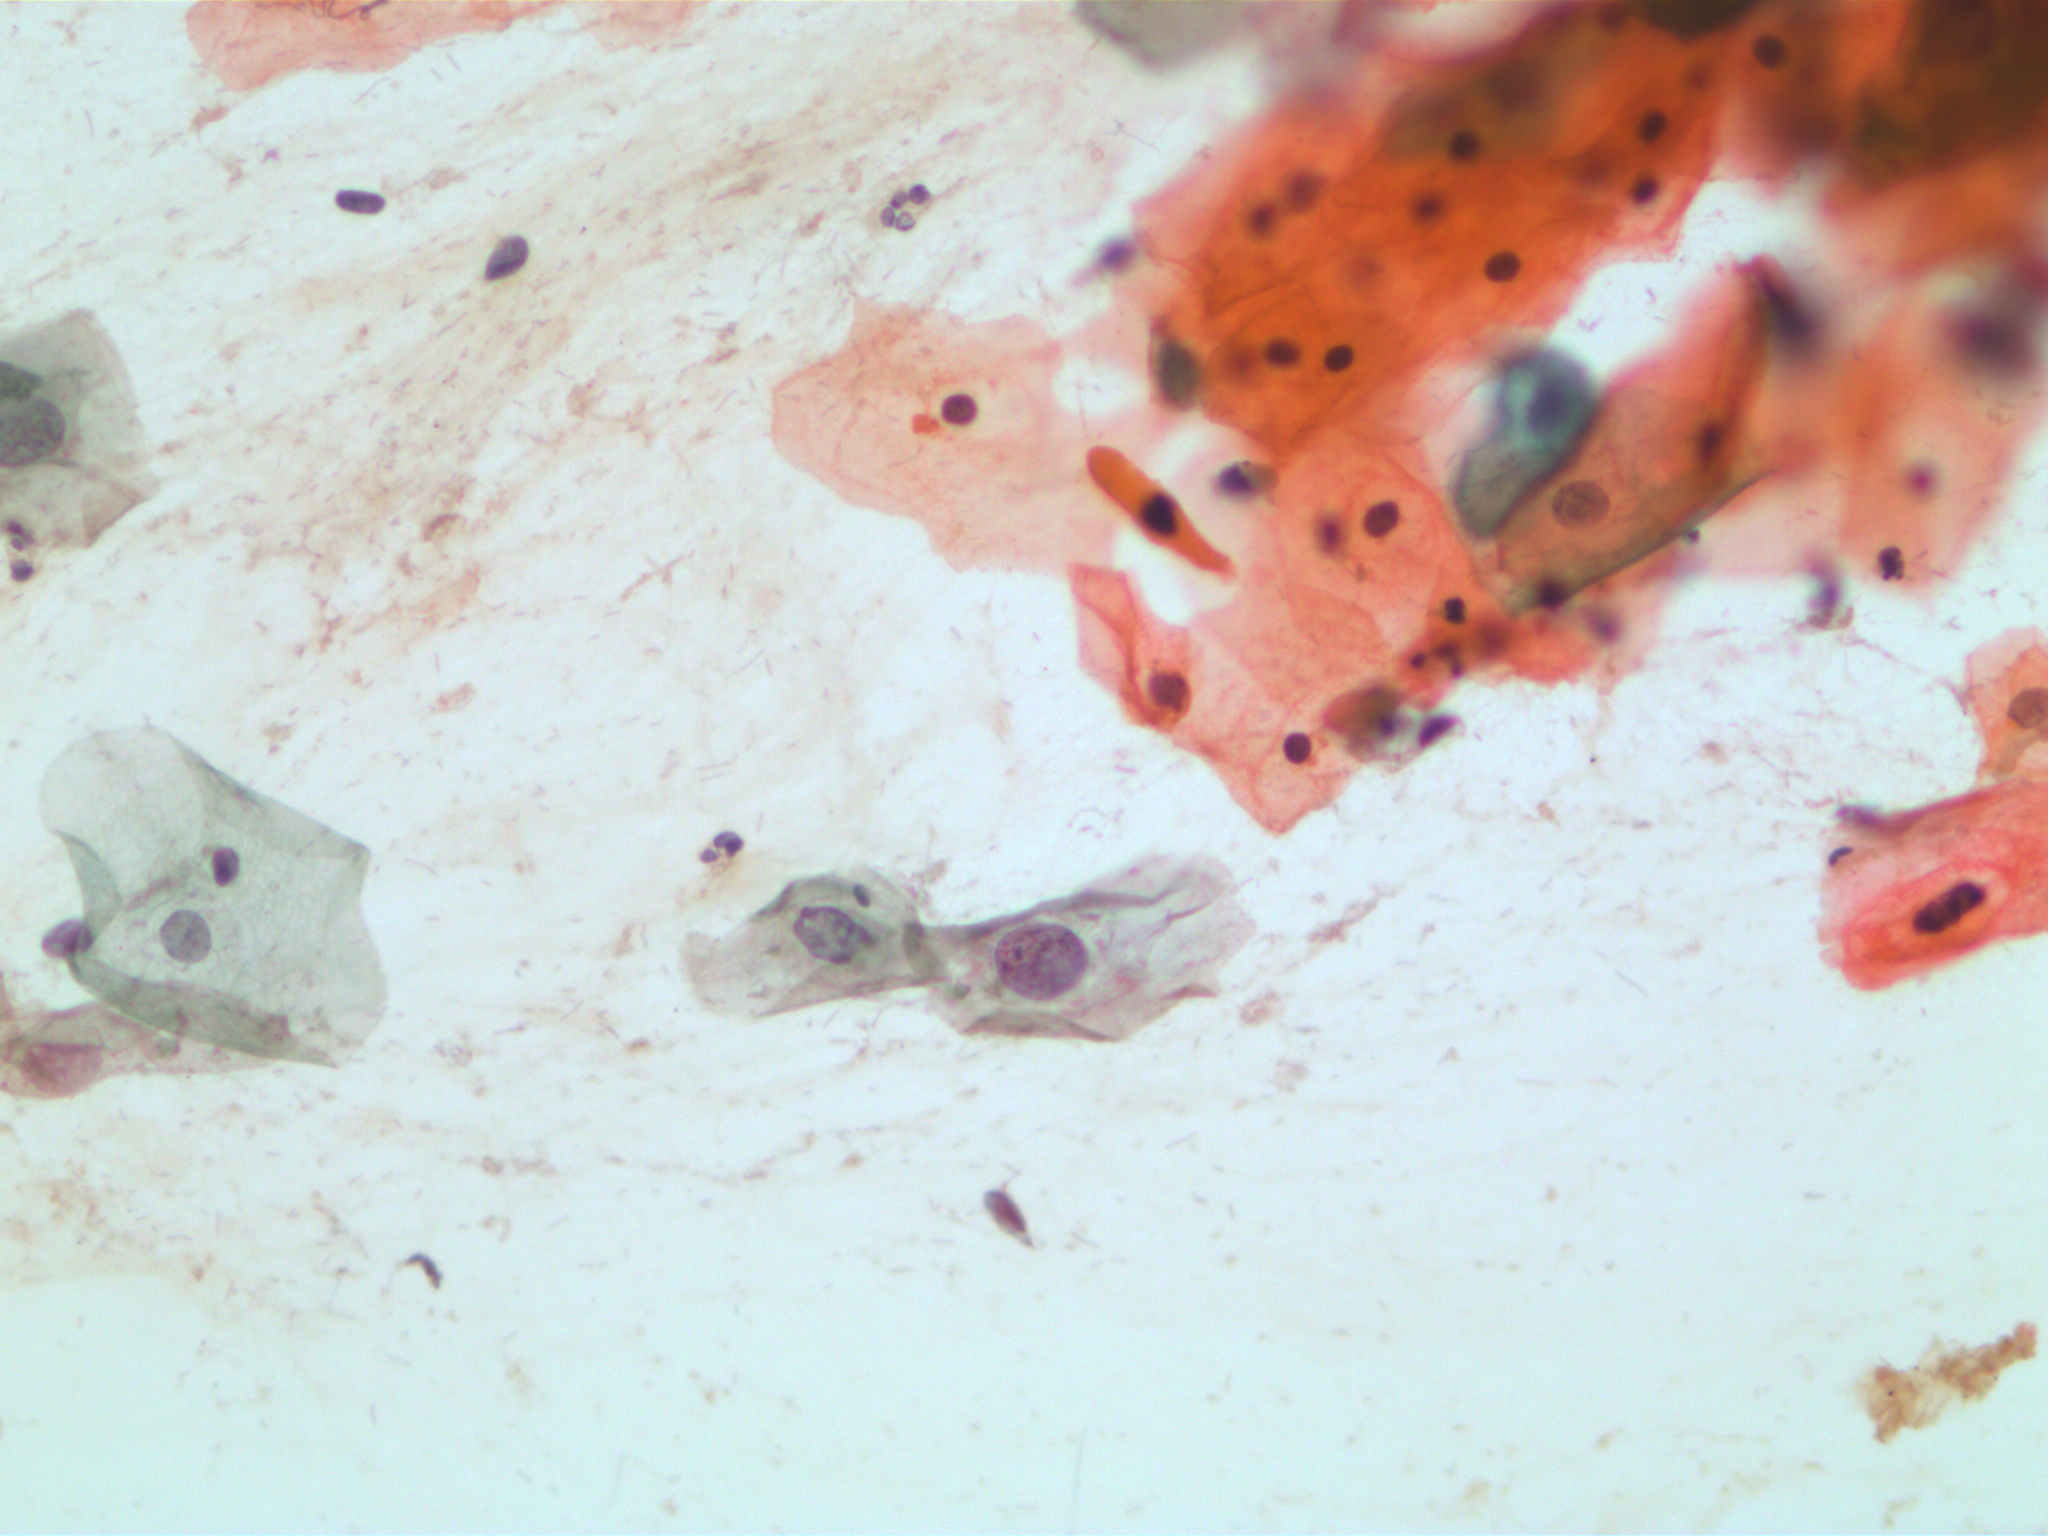

In [ ]:
from IPython.display import Image, display
from PIL import Image as PILImage  # Import PIL's Image class

# ... (other code) ...

# The local path to our target image
img_path = "/content/Datacancer/train/Dys-70/037.bmp"

# Open the image using PIL
pil_img = PILImage.open(img_path)

# Convert the image to a supported format (e.g., PNG)
# and display it using IPython.display.Image
# display(Image(pil_img.tobytes(), format='png'))
# the method 'tobytes()' is deprecated. Instead, we can save the image to a BytesIO object
from io import BytesIO
# Store image data in a buffer
buffer = BytesIO()
pil_img.save(buffer, format='png')

# Display the buffered image
display(Image(data=buffer.getvalue(), format='png'))

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

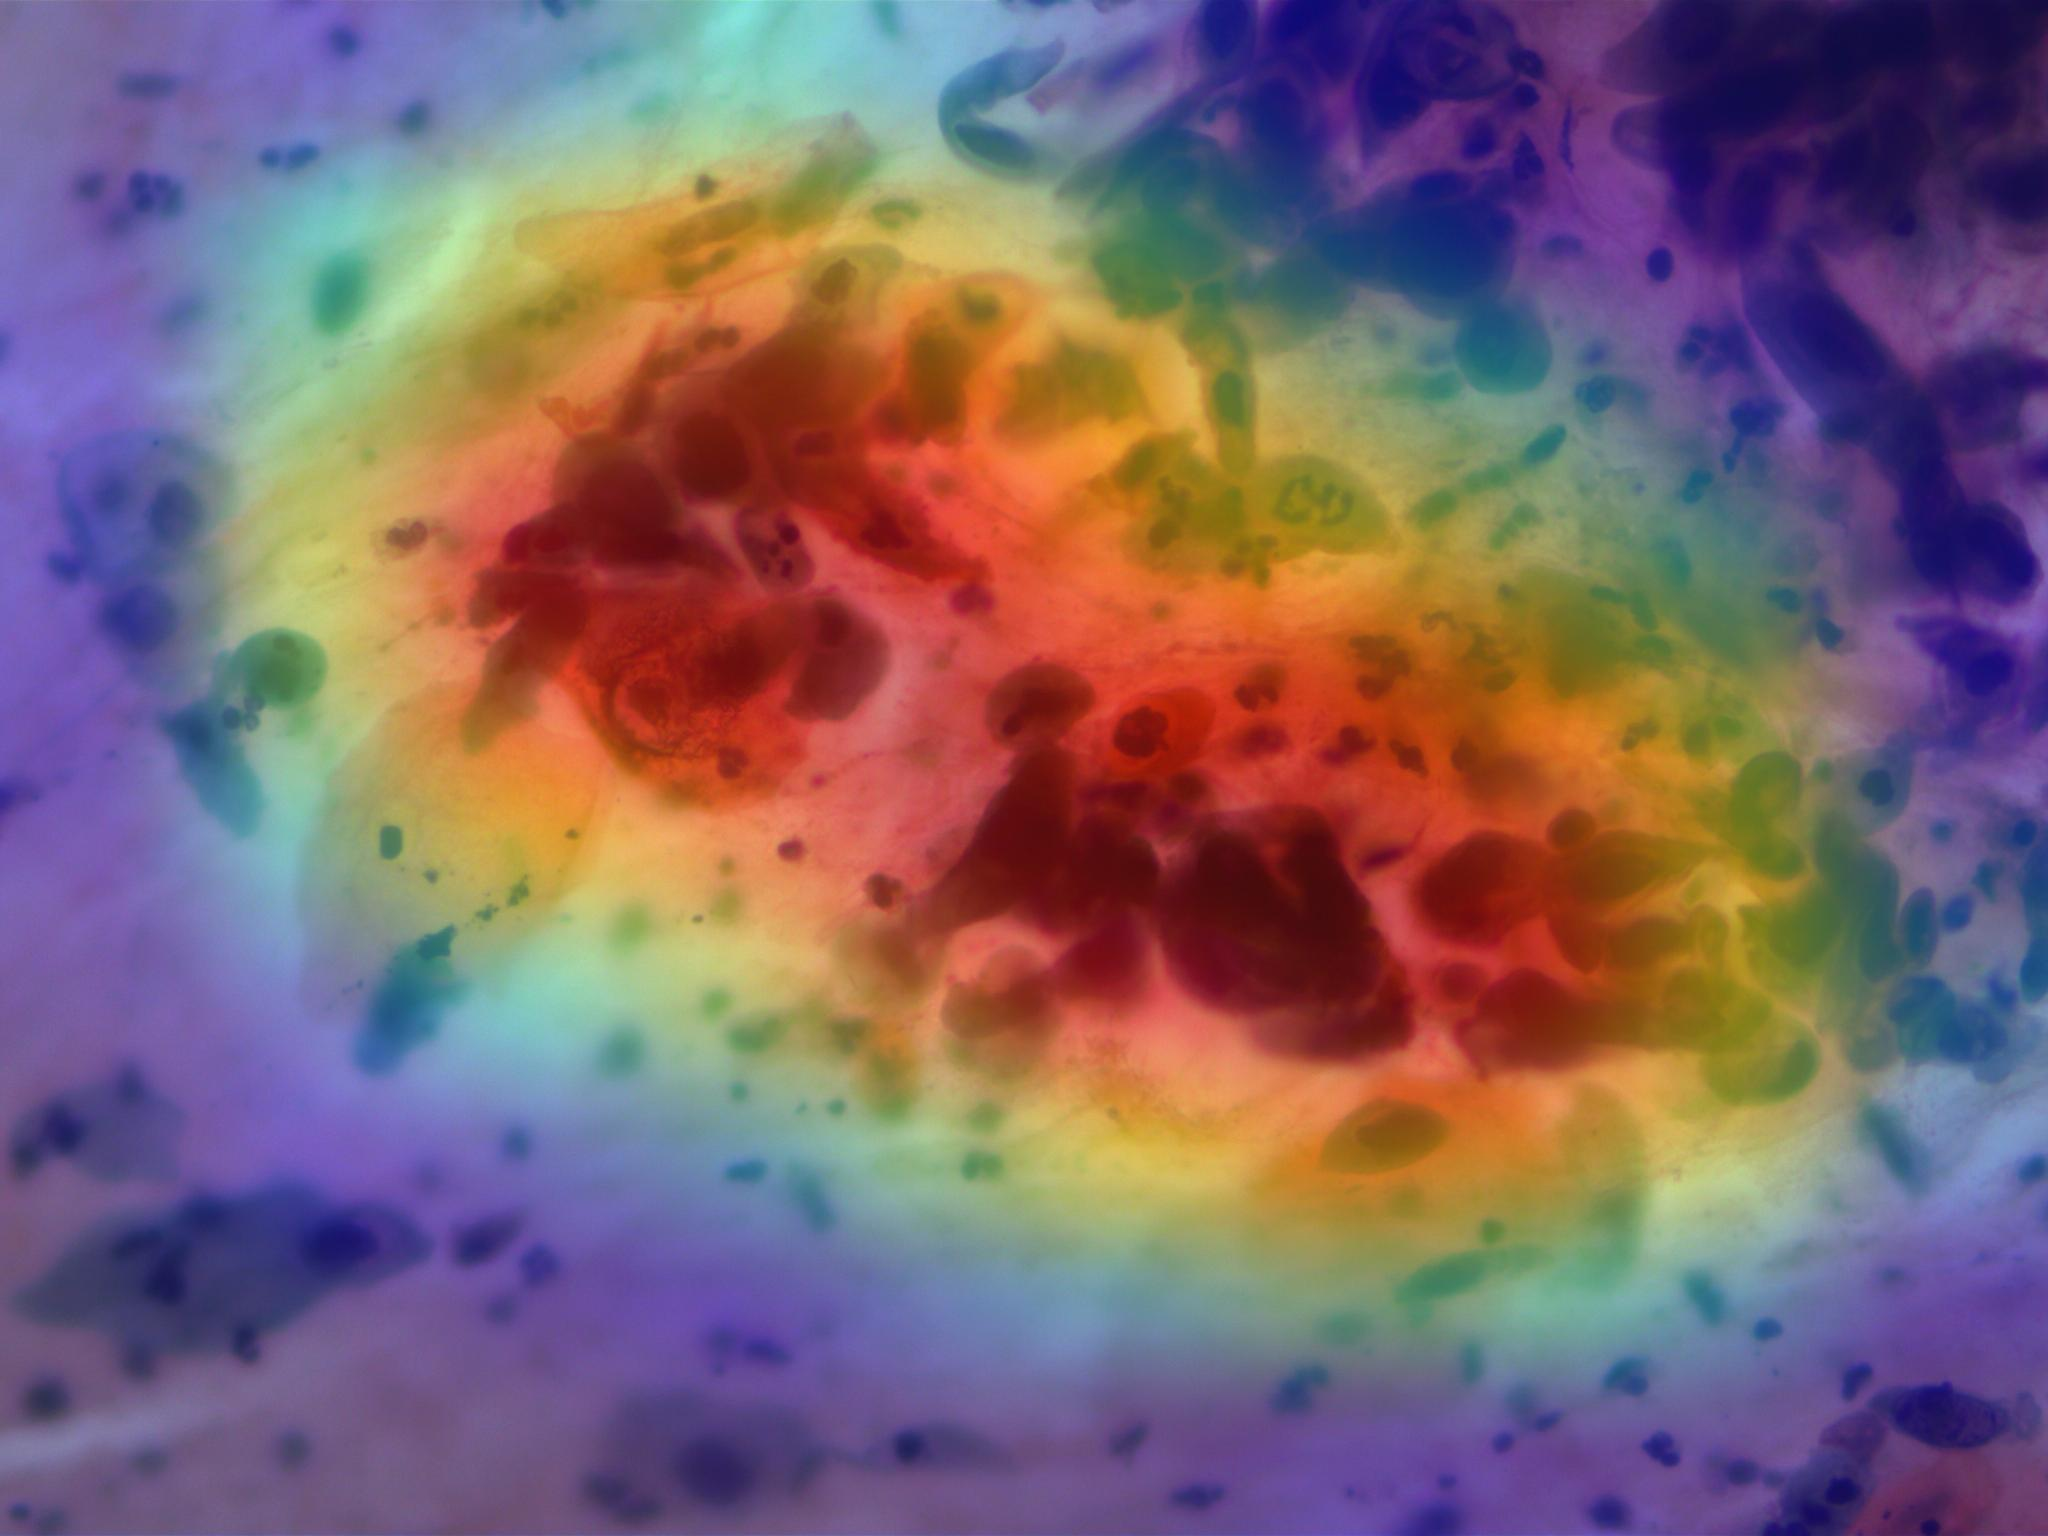

In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)